In [1]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# Mobius SimplyP tutorial: model calibration and uncertainty estimation

This notebook illustrates how to perform auto-calibration and uncertainty analysis using the Mobius Python interface and the [SimplyP](https://github.com/LeahJB/SimplyP) model.

## 1. Compile SimplyP, or obtain a pre-compiled version

To interact with the Mobius version of SimplyP via Python, you first a need to compile the SimplyP dynamic linked library (DLL). On Windows, this will involve installing the g++ compiler and adding it to your system path - see [here](https://github.com/NIVANorge/Mobius#quick-start-guide) for details.

With the compiler installed, download or clone the Mobius repository ([here](https://github.com/NIVANorge/Mobius#quick-start-guide)), then open a `'cmd'` prompt, `'cd'` into 

    Mobius/Applications/SimplyP

and run `'compile_pythonwrapper.bat'`. This will create a file named `'simplyp.dll'` which is imported below.

If this is daunting, feel free to get in touch and we can provide pre-compiled models (contact details on the Mobius homepage).

In [2]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"../mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('../../Applications/SimplyP/simplyp.dll')

# Calibration functions
calib_fpath = (r"../mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

## 2. Select catchment example

Example datasets are available for two catchments: Morsa in Southern Norway and the Tarland Burn in North-eastern Scotland. We'll work with the Morsa dataset in this example.

In [3]:
# Choose the catchment to work with for this example ('Morsa' or 'Tarland')
catchment = 'Tarland' 

# Load dataset
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/%s/%sParameters_v0-3.dat' % (catchment, catchment),
                                                          '../../Applications/SimplyP/%s/%sInputs.dat' % (catchment, catchment))

## 3. Link observed and simulated datasets

In order to assess model performance, we need to be able to compare simulated values to observations. The code below links five simulated data series (Q, SS, TP, TDP and PP) to the relevant observed datasets (as defined in the Mobius `'dataset'` object).

**Note:** "Kure" is a monitoring location in the Morsa catchment, which was used as an "index" when setting up the SimplyP model. The `'comparisons'` list below contains five tuples, each mapping a simulated dataset in the model to an observed data series. The names of the observed data series should match those present in the input .dat file.

**To do**

 * Add wrapper functionality to get a list of possible comparisons directly from the dataset object? 

In [4]:
# List of simulated and observed variables to investigate for Morsa
# comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'], 'Observed Q', []),
#                ('Reach suspended sediment concentration', ['Kure'], 'Observed SS at Kure', []),
#                ('Reach TP concentration', ['Kure'], 'Observed TP at Kure', []),
#                ('Reach TDP concentration', ['Kure'], 'Observed TDP at Kure', []),
#                ('Reach PP concentration', ['Kure'], 'Observed PP at Kure', []),            
#               ]

# List of simulated and observed variables to investigate for Tarland
comparisons = [('Reach flow (daily mean, cumecs)', ['Coull'], 'observed Q', []),
               ('Reach suspended sediment concentration', ['Coull'], 'observed SS', []),
               ('Reach TDP concentration', ['Coull'], 'observed TDP', []),
               ('Reach PP concentration', ['Coull'], 'observed PP', []),            
              ]

## 4. Manual calibration

The original data files (`'MorsaParameters.dat'` and `'MorsaInputs.dat'` for the Morsa catchment) used to create this Mobius `'dataset'` include deafult values and plausible ranges for each model parameter. The code below lists these default values for all the `'double'` parameters defined in the model (these are the ones available for calibration).

In [5]:
# Get parameter values defined in 'dataset'
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

name           unit  \
0                                            Latitude              °   
1              Initial snow depth as water equivalent             mm   
2                      Degree-day factor for snowmelt      mm/°C/day   
3   Proportion of precipitation that contributes t...  dimensionless   
4                           PET multiplication factor  dimensionless   
5                                 Soil field capacity             mm   
6                                      Baseflow index  dimensionless   
7                           Groundwater time constant           days   
8                            Minimum groundwater flow         mm/day   
9                               Manning's coefficient      s/(m^1/3)   
10                                     Catchment area           km^2   
11                                       Reach length              m   
12                                        Reach slope            m/m   
13                             Initial in-stream flow          m^3/s   
14                           Soil water time constant           days   
15                           Soil water time constant           days   
16                           Soil water time constant           days   
17                               Land use proportions  dimensionless   
18                               Land use proportions  dimensionless   
19                               Land use proportions  dimensionless   
20                                 Upstream land area           km^2   
21                             Effective reach length              m   
22                Reach sediment input scaling factor         kg/m^3   
23              Sediment input non-linear coefficient  dimensionless   
24                   Proportion of spring grown crops  dimensionless   
25             Mean slope of land in the subcatchment              °   
26             Mean slope of land in the subcatchment              °   
27             Mean slope of land in the subcatchment              °   
28                            Vegetation cover factor  dimensionless   
29                            Vegetation cover factor  dimensionless   
30                            Vegetation cover factor  dimensionless   
31                      Reduction of load in sediment  dimensionless   
32                      Reduction of load in sediment  dimensionless   
33                      Reduction of load in sediment  dimensionless   
34                                   Soil mass per m2         kg/m^2   
35                   Phosphorous sorption coefficient          mm/kg   
36            Net annual P input to agricultural soil     kg/ha/year   
37         Net annual P input to newly-converted soil     kg/ha/year   
38                      Groundwater TDP concentration           mg/l   
39                    Particulate P enrichment factor  dimensionless   
40                                       SRP fraction  dimensionless   
41                          Reach effluent TDP inputs         kg/day   
42      Initial soil water TDP concentration and EPC0           mg/l   
43      Initial soil water TDP concentration and EPC0           mg/l   
44      Initial soil water TDP concentration and EPC0           mg/l   
45                       Initial total soil P content          mg/kg   
46                       Initial total soil P content          mg/kg   
47                       Initial total soil P content          mg/kg   
48          Land use proportions from newly-converted  dimensionless   
49          Land use proportions from newly-converted  dimensionless   
50          Land use proportions from newly-converted  dimensionless   

                          index      min_value  initial_value      max_value  
0                            ()  -9.000000e+01      59.600000   9.000000e+01  
1                            ()   0.000000e+00       0.000000   5.000000e+04  
2                            ()   0.000000e+00       2.740000   5.0

Note the `'index'` column in this dataframe, which specifies how each parameter varies within the model structure. For example, the `'Vegetation cover factor'` takes different values for different land use classes, while the `'Mean slope of land'` parameters vary both by land class and river reach.

For this particular dataset, the default values in the `'initial_value'` column were informed by manual calibration using the Mobius [GUI application](https://github.com/NIVANorge/Mobius#building-incaview-compatible-exes). We can easily run the model with these values and assess the goodness-of-fit. The functions below produce one plot and one set of summary statistics for each dataset in `'comparisons'`.


Goodness of fit for Reach flow (daily mean, cumecs) [Coull] vs observed Q []:
Mean error (bias): 0.032003
Mean absolute error: 0.146508
Mean square error: 0.046430
Nash-Sutcliffe coefficient: 0.689684
Number of observations: 479


Goodness of fit for Reach suspended sediment concentration [Coull] vs observed SS []:
Mean error (bias): 2.613284
Mean absolute error: 11.751877
Mean square error: 1012.043851
Nash-Sutcliffe coefficient: 0.131608
Number of observations: 397


Goodness of fit for Reach TDP concentration [Coull] vs observed TDP []:
Mean error (bias): 0.000501
Mean absolute error: 0.007775
Mean square error: 0.000121
Nash-Sutcliffe coefficient: 0.128392
Number of observations: 398


Goodness of fit for Reach PP concentration [Coull] vs observed PP []:
Mean error (bias): 0.007013
Mean absolute error: 0.021509
Mean square error: 0.001428
Nash-Sutcliffe coefficient: 0.017804
Number of observations: 383



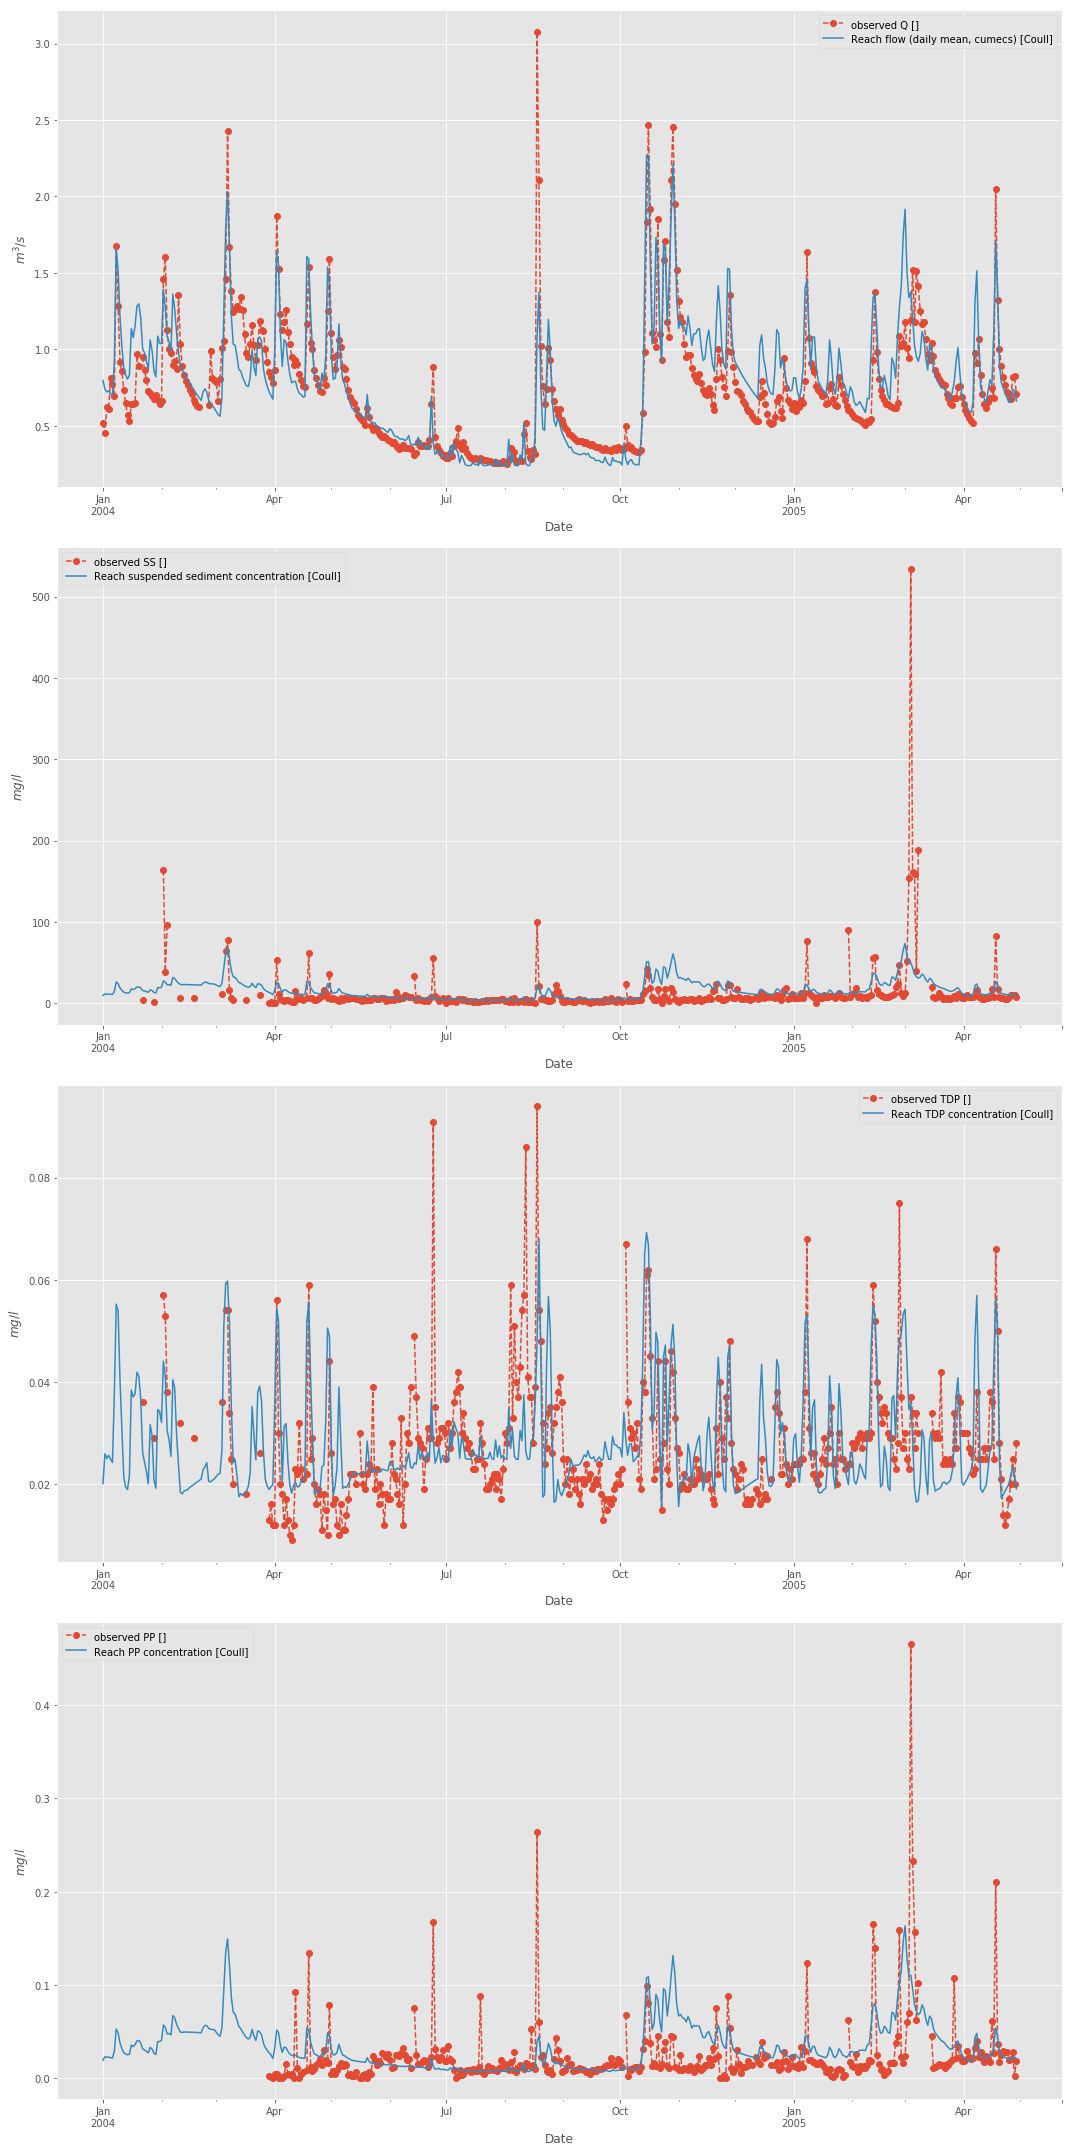

In [6]:
# Plot results from manual calibration
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

## 5. Auto-calibration

### 5.1. Choose parameters to calibrate

Parameter values should be informed by system knowledge wherever possible. In this example, we will choose to calibrate a sub-set of model parameters that are poorly constrained.

The code below selects **11 parameters** for further investigation.

**Note:** Several Pandas methods can be used to subset `'param_df'`. The approach illustrated below is simple, but rather rough and error-prone.  Consider using e.g. [`'df.query'`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) instead to explicitly select parameters by name and index.

In [7]:
# Get params to be calibrated
calib_df = param_df.loc[[2, 3, 4, 6, 7, 16, 22, 42, 38, 39, 41]].reset_index(drop=True)
calib_df

name           unit  \
0                      Degree-day factor for snowmelt      mm/°C/day   
1   Proportion of precipitation that contributes t...  dimensionless   
2                           PET multiplication factor  dimensionless   
3                                      Baseflow index  dimensionless   
4                           Groundwater time constant           days   
5                            Soil water time constant           days   
6                 Reach sediment input scaling factor         kg/m^3   
7       Initial soil water TDP concentration and EPC0           mg/l   
8                       Groundwater TDP concentration           mg/l   
9                     Particulate P enrichment factor  dimensionless   
10                          Reach effluent TDP inputs         kg/day   

              index  min_value  initial_value  max_value  
0                ()       0.00           2.74        5.0  
1                ()       0.00           0.02        1.0  
2                ()       0.00           1.00        1.0  
3                ()       0.00           0.70        1.0  
4                ()       0.50          65.00      400.0  
5   (Semi-natural,)       0.05          10.00       40.0  
6                ()       0.00          16.00     1000.0  
7         (Arable,)       0.00           0.10       10.0  
8                ()       0.00           0.02       10.0  
9                ()       1.00           1.60        5.0  
10         (Coull,)       0.00           0.10       10.0

In order to easily refer to model parameters in the subsequent code, and to facilitate creation of tidy plots, it is useful to have abbreviated parameter names. These are defined below.

**Note:** Short names for model parameters **must not** begin with `'err_'`, otherwise conflicts will arise with error terms used in the MCMC analysis (see section 6.2, below).

**To do**

 * Require the user to define a `'short_name'` for each parameter in the original dataset file. These names are useful and defining them here is messy.

In [8]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = ['DDFmelt',
                          'fquick',
                          'alphaPET',
                          'BFI',
                          'T_gw',
                          'Ts_SN',
                          'k_sed',
                          'TDP_sw',
                          'TDP_gw',
                          'E_PP',
                          'TDPeff',
                          ]

Having defined a dataframe of parameters we wish to calibrate, complete with short names, initial values and minimum to maximum ranges, we can instantiate an [LMFit Parameters](https://lmfit.github.io/lmfit-py/parameters.html) object, which makes it easy to keep track of bounded parameter values. 

In [9]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)

It is easy to modify the prior ranges for each parameter, as illustrated in the code below. Initial values can also be changed using e.g. `'params['DDFmelt'].value = 2.5'`, or calibration can be disabled entirely for specific parameters using e.g. `'params['DDFmelt'].vary = False'`. Note that parameters must be referred to by their `'short_name'` attribute.

In [13]:
# Optionally refine prior ranges
params['DDFmelt'].min = 0.5
params['DDFmelt'].max = 4

params['fquick'].min = 0.002
params['fquick'].max = 0.2

params['alphaPET'].min = 0.5
params['alphaPET'].max = 1.5

params['BFI'].min = 0.1
params['BFI'].max = 0.7

params['T_gw'].min = 15
params['T_gw'].max = 100

params['Ts_SN'].min = 1
params['Ts_SN'].max = 15

params['k_sed'].min = 10
params['k_sed'].max = 200

params['TDP_sw'].min = 0.05
params['TDP_sw'].max = 0.2

params['TDP_gw'].min = 0.001
params['TDP_gw'].max = 0.03

params['E_PP'].min = 1
params['E_PP'].max = 4

params['TDPeff'].min = 0.05
params['TDPeff'].max = 3.5

The `'pretty_print'` statement provides a convenient summary of the calibrating parameters and prior ranges we have specified so far.

In [14]:
params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name         Value      Min      Max     Vary
BFI            0.6      0.1      0.7     True
DDFmelt       2.74      0.5        4     True
E_PP           1.6        1        4     True
TDP_gw        0.02    0.001     0.03     True
TDP_sw         0.1     0.05      0.2     True
TDPeff         0.1     0.05      3.5     True
T_gw            65       15      100     True
Ts_SN           10        1       15     True
alphaPET         1      0.5      1.5     True
fquick        0.02    0.002      0.2     True
k_sed           16       10      200     True


### 5.2. Least squares optimisation

LMFit provides a convenient API to several Python optimisers (see [here](https://lmfit.github.io/lmfit-py/fitting.html#the-minimize-function) for details). 

Some of these optimisers also provide confidence intervals and correlations for the "best" parameters. These are approximate, but they provide useful information about the model and may help you to refine parameter ranges (or even the model structure) before undertaking a more comprehensive calibration exercise using MCMC (see below).

All of these optimisers aim to minimise the sum of squared residuals. From a "formal" statistical point of view, this is equivalent to assuming a likelihood function with independent and identically distributed (i.i.d.) Gaussian errors, which may not be the best choice. Nevertheless, minimising the sum of squared errors is often a good starting point, especially given the range of optimisers available.

**Note:** Performance can vary dramatically between optimisers, so it's often a good idea to try a few different alternatives. This will also allow you to check whether the same "optimum" is identified by the various algorithms.

In [15]:
%%time
# Minimise using Levenberg–Marquardt (gives similar output to Nelder-Mead, 
# but in this case it's faster)
mi, res = cu.minimize_residuals(params, dataset, comparisons, method='leastsq', norm=True, 
                                skip_timesteps=30)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 176
    # data points      = 1624
    # variables        = 11
    chi-square         = 3365.86453
    reduced chi-square = 2.08671081
    Akaike info crit   = 1205.55919
    Bayesian info crit = 1264.87832
[[Variables]]
    DDFmelt:   3.99999129 +/- 0.71168261 (17.79%) (init = 2.74)
    fquick:    0.00485070 +/- 0.01427483 (294.28%) (init = 0.02)
    alphaPET:  0.91919755 +/- 0.03210700 (3.49%) (init = 1)
    BFI:       0.69999998 +/- 0.05250910 (7.50%) (init = 0.6)
    T_gw:      100.000000 +/- 30.8600246 (30.86%) (init = 65)
    Ts_SN:     4.98931467 +/- 3.12119816 (62.56%) (init = 10)
    k_sed:     14.2919430 +/- 0.85422192 (5.98%) (init = 16)
    TDP_sw:    0.07995100 +/- 0.01680212 (21.02%) (init = 0.1)
    TDP_gw:    0.01481723 +/- 0.00855945 (57.77%) (init = 0.02)
    E_PP:      1.23986942 +/- 0.09927442 (8.01%) (init = 1.6)
    TDPeff:    0.43368360 +/- 0.35014427 (80.74%) (init

For Morsa, the optimiser runs the model around 300 times in around 45 seconds, which is much faster than the original pure Python implementation of SimplyP. 

Output includes estimated parameter correlations and confidence intervals: note, for example, the `'Stderr'` column that has been added to the parameters table immediately above.

### 5.3. Visualise results

To see the model output for the optimised parameter values, first use `'set_parameter_values'` to update the default values, and then re-run the model, as above.


Goodness of fit for Reach flow (daily mean, cumecs) [Coull] vs observed Q []:
Mean error (bias): 0.069835
Mean absolute error: 0.147065
Mean square error: 0.044420
Nash-Sutcliffe coefficient: 0.703121
Number of observations: 479


Goodness of fit for Reach suspended sediment concentration [Coull] vs observed SS []:
Mean error (bias): 1.632947
Mean absolute error: 10.951053
Mean square error: 998.710668
Nash-Sutcliffe coefficient: 0.143048
Number of observations: 397


Goodness of fit for Reach TDP concentration [Coull] vs observed TDP []:
Mean error (bias): -0.000203
Mean absolute error: 0.007283
Mean square error: 0.000100
Nash-Sutcliffe coefficient: 0.281557
Number of observations: 398


Goodness of fit for Reach PP concentration [Coull] vs observed PP []:
Mean error (bias): -0.001416
Mean absolute error: 0.016776
Mean square error: 0.001211
Nash-Sutcliffe coefficient: 0.167038
Number of observations: 383



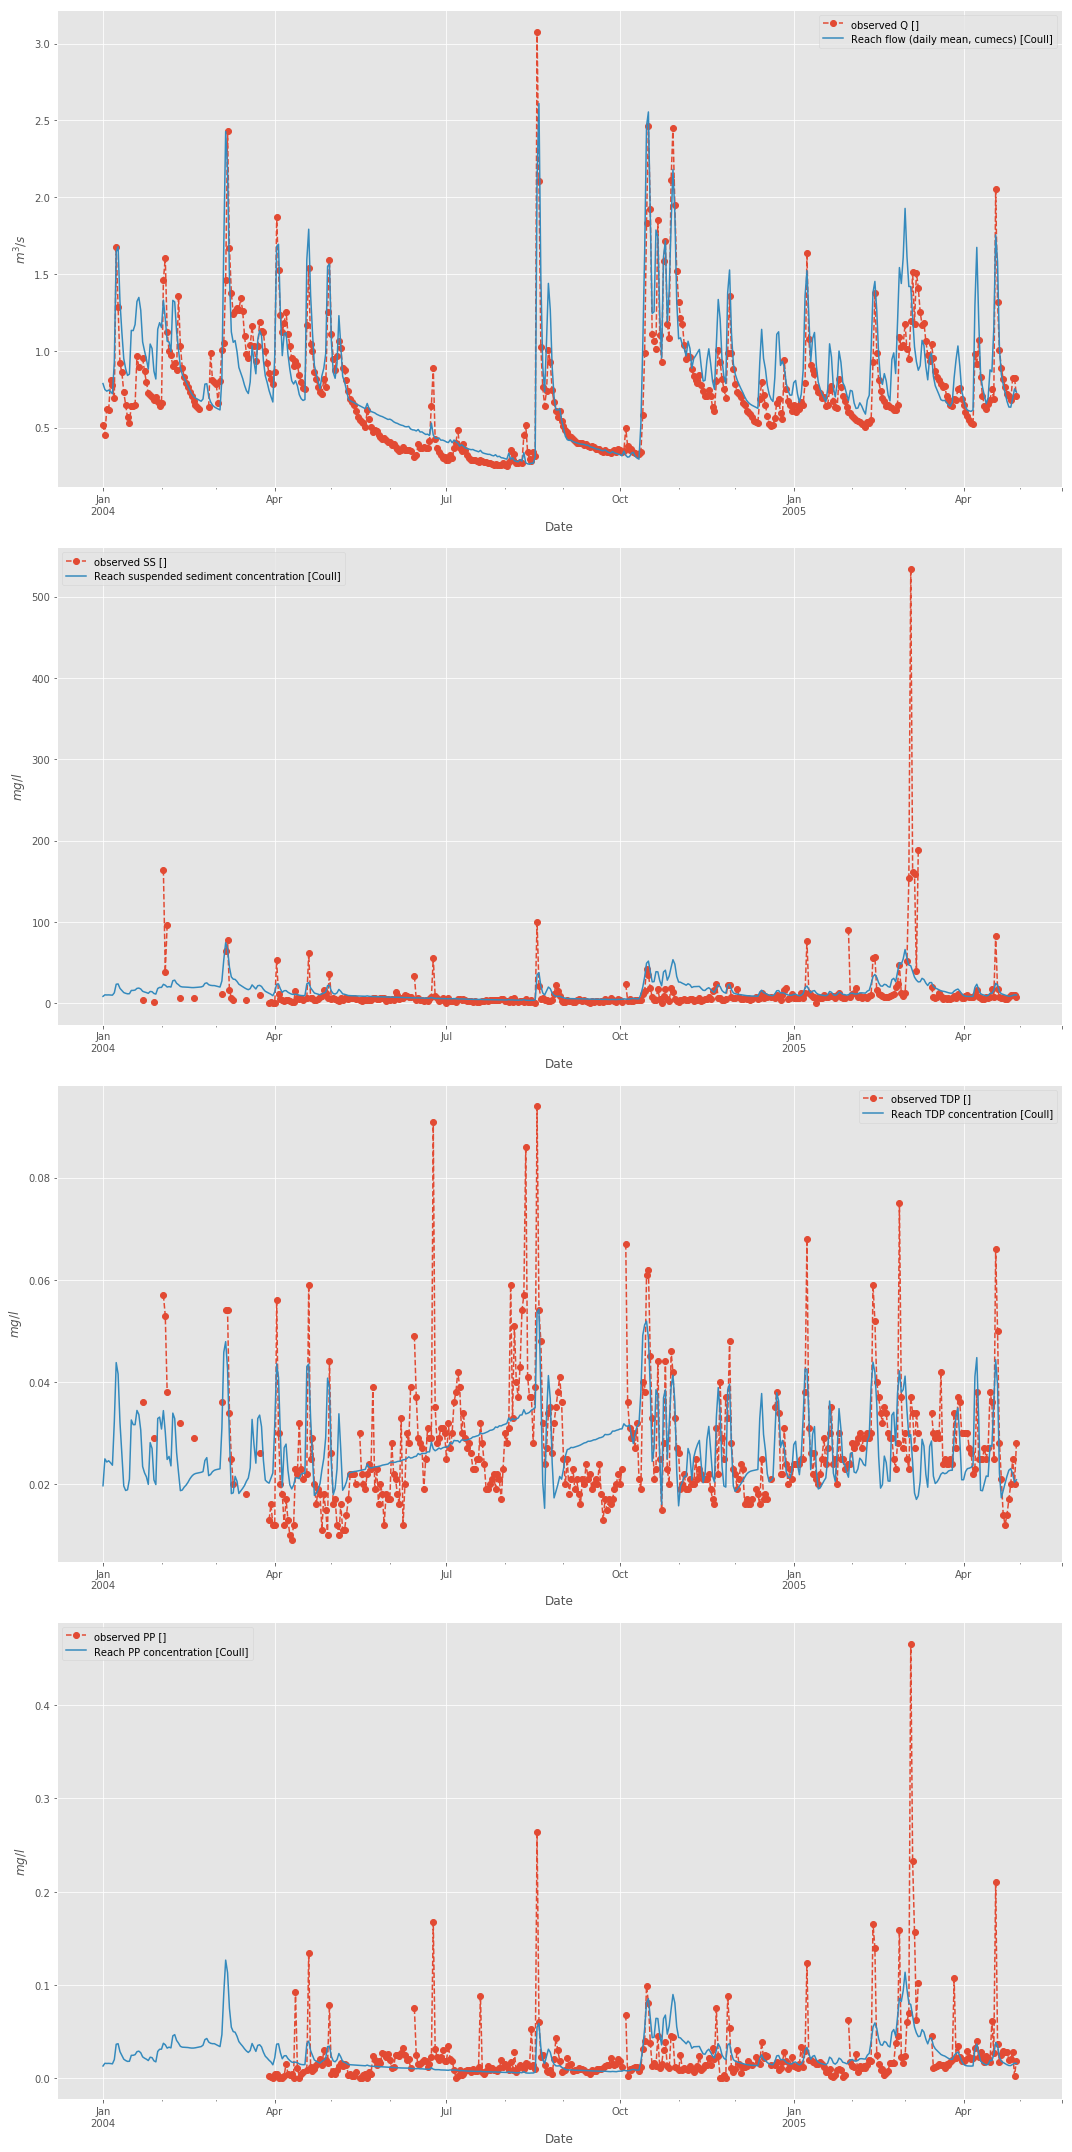

In [16]:
# Plot results from optimisation
cu.set_parameter_values(res.params, dataset)
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

## 6. Full calibration and uncertainty analysis using MCMC

Bayesian MCMC provides much more comprehensive information regarding model performance, but it's also more complicated and computationally intensive. Although it's perfectly possible to begin your model analysis with MCMC, it's usually a good idea to experiment with the optimisation options described above first, and then apply MCMc as a second step.

### 6.1. Likelihood function

The (log) likelihood function describes the probability that the model, when run with a given set of parameters, will reproduce the observed data. Formulating an appropriate likelihood function is both important and challenging, and there's a lot of literature on the subject. In this example, we'll assume **heteroscedastic**, independent Gaussian errors, which is one step better than the simplest/commonest i.i.d. approach. If you'd like to know more about where this approach comes from, see [here](http://jamessample.github.io/enviro_mod_notes/) (especially [section 2 of notebook 6](https://nbviewer.jupyter.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/06_Beyond_Metropolis.ipynb#2.-Choosing-a-likelihood-function)).

In order to run parallelised MCMC, you need to create a separate Python file similar to `'simplyp_calib_uncert.py'`. This file defines your log likelihood function and provides the Mobius `'dataset'` as a "top-level object", which makes it amenable to parallel processing.

**To do**

 * See if we can figure out parallelisation from within Jupyter?

### 6.2. Error terms

Using a formal statistical likelihood involves estimating some additional error terms. We'll assume that the error distribution for all three phosphorus species is the same, so we need three terms in total (for Q, SS and P). These can be added to the result obtained from the optimiser in section 5, above.

**Note:** Names for error terms **must** begin with `'err_'`. Conversely, short names for model parameters **must not** begin with `'err_'`.

In [17]:
# Add error params
res.params.add('err_q', value=0.5, min=0.05, max=3)
res.params.add('err_ss', value=0.5, min=0.05, max=5)
res.params.add('err_p', value=0.5, min=0.05, max=2)

res.params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name         Value      Min      Max     Vary
BFI            0.7      0.1      0.7     True
DDFmelt          4      0.5        4     True
E_PP          1.24        1        4     True
TDP_gw     0.01482    0.001     0.03     True
TDP_sw     0.07995     0.05      0.2     True
TDPeff      0.4337     0.05      3.5     True
T_gw           100       15      100     True
Ts_SN        4.989        1       15     True
alphaPET    0.9192      0.5      1.5     True
err_p          0.5     0.05        2     True
err_q          0.5     0.05        3     True
err_ss         0.5     0.05        5     True
fquick    0.004851    0.002      0.2     True
k_sed        14.29       10      200     True


We also need to define a dictionary matching each of the observed data series in `'comparisons'` to the appropriate error term.

In [15]:
## Link error params to model datasets

# For the Morsa catchment, uncomment this.
# We decide here that all phosphorus species will share a single error term, err_p:
#error_param_dict = {'Observed Q':          'err_q',
#                    'Observed SS at Kure': 'err_ss',
#                    'Observed TP at Kure': 'err_p',
#                    'Observed TDP at Kure':'err_p',
#                    'Observed PP at Kure': 'err_p',
#                   }

# For the Tarland catchment, comment out the above and uncomment this
# As in Morsa, we decide that TDP and PP will share an error term, err_p:
error_param_dict = {'observed Q':  'err_q',
                    'observed SS': 'err_ss',
                    'observed TDP':'err_p',
                    'observed PP': 'err_p',
                   }

**Note:** LMFit parameter objects provide additional features for linking and combining parameters using the `'expr'` argument - see [here](https://lmfit.github.io/lmfit-py/constraints.html) for further details. The error terms for TDP and PP could equally well have been defined as follows:

    # Add error params
    res.params.add('err_q', value=0.5, min=0.05, max=3)
    res.params.add('err_ss', value=0.5, min=0.05, max=5)
    res.params.add('err_tp', value=0.5, min=0.05, max=2)
    res.params.add('err_tdp', expr='err_tp')             # Use a single error term for all P types
    res.params.add('err_pp', expr='err_tp')              # Use a single error term for all P types 
    
Although not necessary here, this kind of syntax is especially useful when dealing with parameters representing proportions, where the total need to be constant.

### 6.3. MCMC options

In order to run the MCMC in parallel, all the settings from above are added to a dictionary and "pickled". Some additional options are specified below.

**To do**

 * Currently, the dataset paths need to be hard-coded in `'simplyp_calib_uncert.py'`. It would be nice to figure out how to pass these in "dynamically", without breaking the parallelisation

In [16]:
# emcee setup
nworkers = 8    # Number of cores/processes for parallelisation
ntemps = 1      # Number of temperatures for parallel tempering (use 1 for default ensemble sampler)
nsteps = 1000   # Number of steps per chain
nwalk = 100     # Number of chains/walkers
nburn = 500     # Number of steps to discard as burn-in
thin = 1        # Keep only every 'thin' steps to reduce chain auto-correlation

# Chain initialisation
# 'uniform' => Chain starting locations sampled uniformly from prior
# 'optimum' => Chain starting locations sampled from a small Gaussian ball in vicinity of optimum
init_chains = 'uniform'  # Or 'optimum'. 

skip_timesteps = 30  # Number of time steps to skip before calulating fit

# Result file paths
result_path = r'pickled/mcmc_results.pkl'
chain_plot_path = r'simplyp_plots/chains.png'
corner_plot_path = r'simplyp_plots/corner.png'

In [17]:
# Save settings for passing to MCMC
settings_dict = {'params':res.params,
                 'error_param_dict':error_param_dict,
                 'comparisons':comparisons,
                 'skip_timesteps':skip_timesteps,
                 'nworkers':nworkers,
                 'ntemps':ntemps,
                 'nsteps':nsteps,
                 'nwalk':nwalk,
                 'nburn':nburn,
                 'thin':thin,
                 'init_chains':init_chains,
                 'result_path':result_path,
                 'chain_path':chain_plot_path,
                 'corner_path':corner_plot_path,                 
                }

with open('pickled/mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

### 6.4. Run MCMC

Time elapsed running emcee: 37.51 minutes.

Quantiles:
[(0.025, 1.2538406466380172), (0.5, 1.4193066378232637), (0.975, 3.2562457955070845)]
Quantiles:
[(0.025, 0.038239066614727854), (0.5, 0.050540646753264314), (0.975, 0.06491111020218289)]
Quantiles:
[(0.025, 0.9144750379857296), (0.5, 0.9326405251206756), (0.975, 0.95063712176839)]
Quantiles:
[(0.025, 0.581389125287885), (0.5, 0.5947898867566741), (0.975, 0.5997927946660295)]
Quantiles:
[(0.025, 91.17658927684039), (0.5, 97.69919009045246), (0.975, 99.8939934460309)]
Quantiles:
[(0.025, 9.004798005801614), (0.5, 11.417971297928954), (0.975, 14.022670140155181)]
Quantiles:
[(0.025, 10.234690320296387), (0.5, 11.708626970807748), (0.975, 13.423969234851516)]
Quantiles:
[(0.025, 0.050495312985073995), (0.5, 0.055213436662485633), (0.975, 0.061777472781888644)]
Quantiles:
[(0.025, 0.007588965616919844), (0.5, 0.01350897037846557), (0.975, 0.018243576462163666)]
Quantiles:
[(0.025, 2.1930651866879476), (0.5, 2.5837120909970106), (0.975,

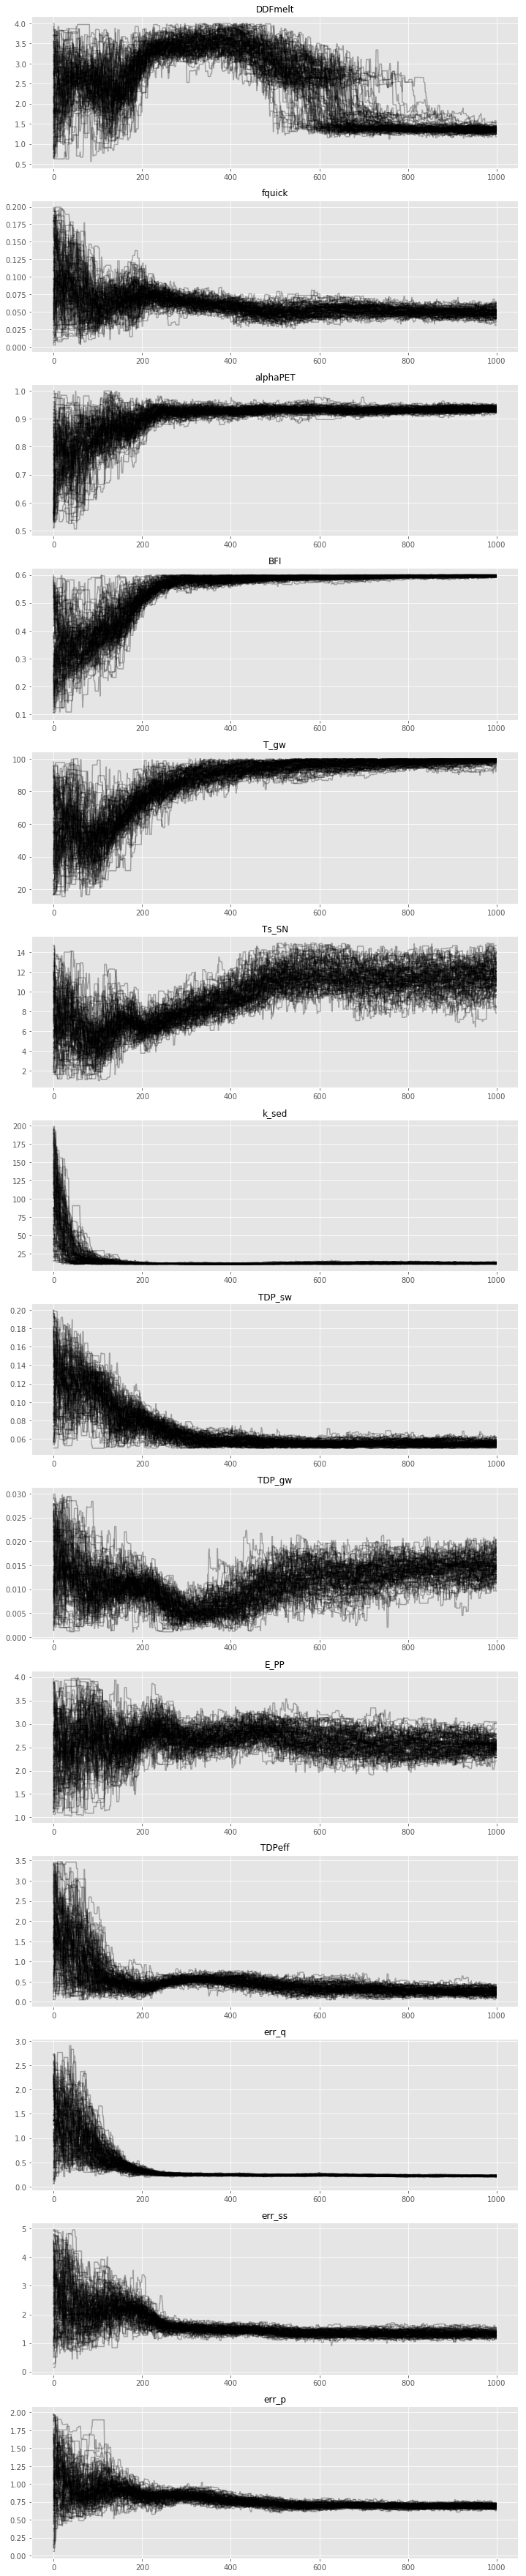

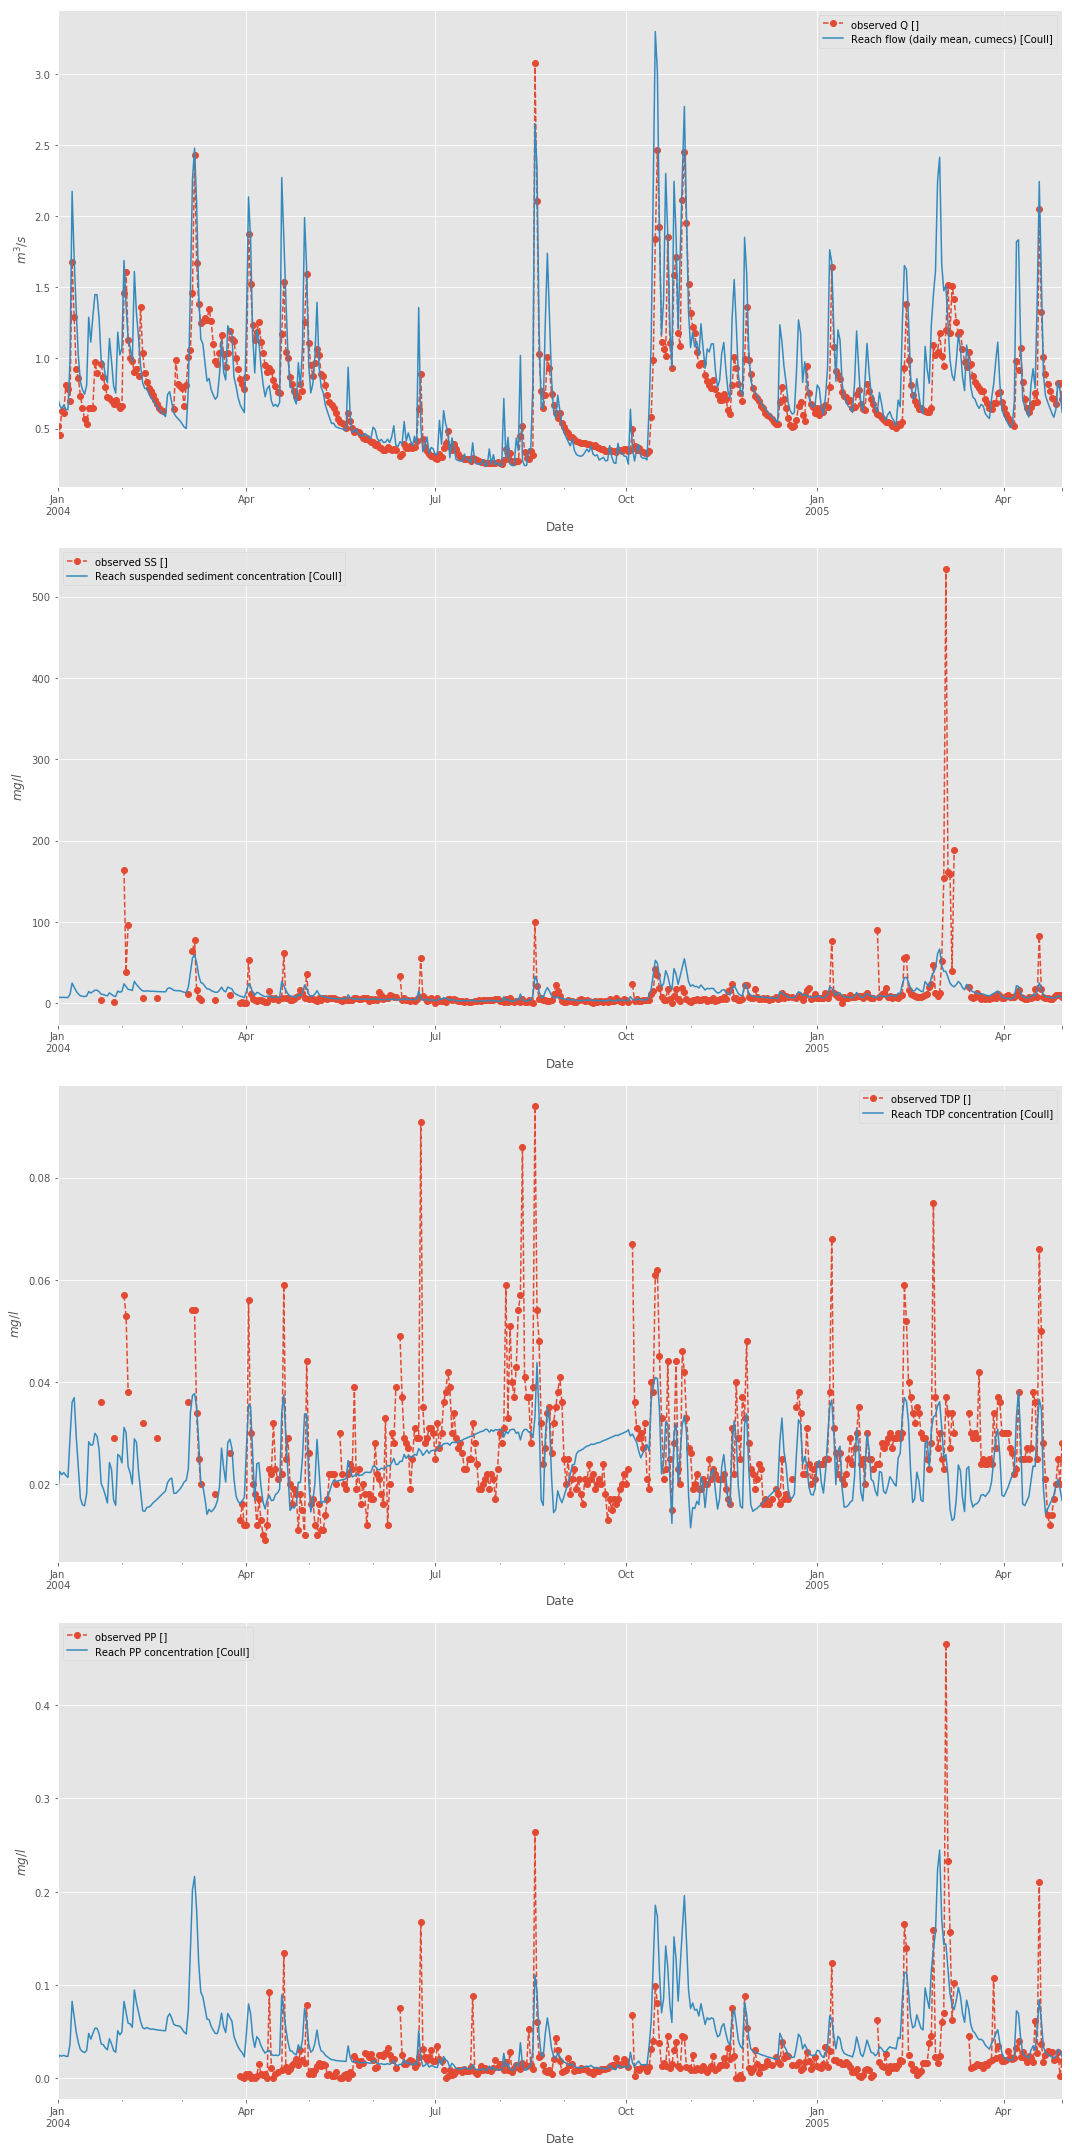

In [19]:
%run -i simplyp_calib_uncert.py

### 6.5. Parameter and predictive uncertainty

**To do**

 * Add function to `'mobius_calib_uncert_lmfit.py'` to sample from posterior and create time series showing parameter and predictive uncertainty